## Homework 4 - Joint submission by Noor Pratap Singh and Hirak Sarkar

In [126]:
suppressMessages(library(igraph))

In [127]:
### Loading the data
timeData <- read.csv('roi_timeseries.csv', row.names = 1)
rownames(timeData) <- gsub(" ", "_", unlist(strsplit(rownames(timeData), split = "'", fixed = T)))[seq(2,78,2)]

In [128]:
##Converting an upper triangular matrix into normal matrix
makeSymm <- function(N, corPvals, adjPval)
{
    corPvals[corPvals < adjPval] = 1
    corPvals[corPvals >= adjPval & corPvals != 1] = 0
    #print(sum(corPvals == 1))
    mat <- matrix(0, N, N)
    mat[upper.tri(mat)] <- corPvals
    mat[lower.tri(mat)] <- t(mat[upper.tri(mat)])
    
    return(mat)
}

### Building a Correlation Network

In [129]:
corTimeData <- cor(t(timeData), method = "pearson") ##Computing correlation
z <- 0.5*log((1+corTimeData)/(1-corTimeData)) ##Fischer Transformation
N <- dim(timeData)[2]

zreq <- z[upper.tri(z)]
corPvals <- 2*(1-pnorm(abs(zreq), 0, 1/sqrt(N-3)))

print(length(zreq))
print(sum(corPvals < 0.05))

[1] 741
[1] 428


The total number of checked pairs are 741 (checking only the upper half of matrix since the lower half is symmetric)
The total number of correlated pairs without multiple testing correction are 428 keeping significant threshold to be 0.05

In [27]:
corAdj <- p.adjust(corPvals, "BH") ##Multiple test correction
sum(corAdj < 0.05)

[1] 389

We use Benjamini-Hochberg (BH) correction for multiple test correction and get 389 pairs after correction. We keep the FDR (Flase Discovery rate at 5%). BH is the most widely used method for correction and has thus been also used for the analysis in this paper.

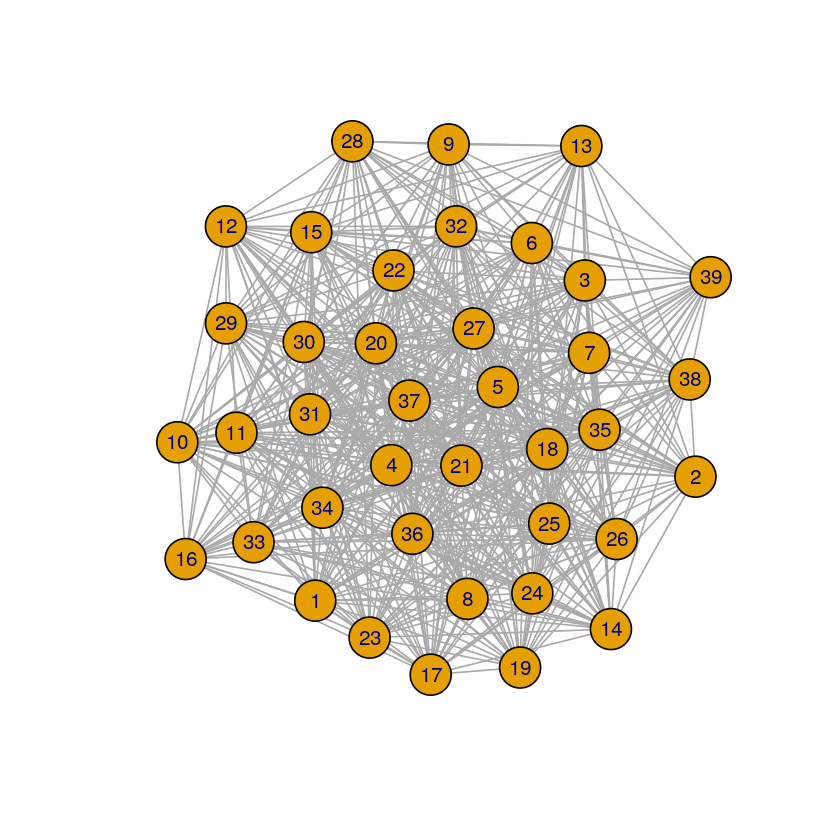

In [84]:
mat <- makeSymm(dim(timeData)[1], corAdj, 0.05)
graphCor <- graph_from_adjacency_matrix(mat, mode = "undirected")
plot(graphCor)

In [87]:
mean(degree(graphCor))

[1] 19.94872

### Building Partial Correlation Network

In [58]:
#Matrix containing partial correlation pvalues
corPartial <- array(0, dim = c(dim(timeData)[1], dim(timeData)[1]))

#Matrix storing regression residuals for every vertex w.r.t every other vertex
resMatList <- matrix(list(), dim(corPartial)[1], dim(corPartial)[1], 
                     dimnames = list(rownames(timeData), rownames(timeData)))

#Taking transpose of data frame
reqDf <- as.data.frame(t(timeData))
for(i in seq(nrow(corPartial)))
{
    for(j in seq(nrow(corPartial)))
    {
        if(i != j)
        {
            form <- as.formula(paste(rownames(timeData)[i], "~", rownames(timeData)[j]))
            resMatList[rownames(timeData)[i], rownames(timeData)[j]] <- list(lm(form, data = reqDf)$residuals)   
        }
    }
}

##Computing partial correlation
N <- dim(timeData)[2]
for(i in seq(nrow(corPartial)))
{
    for(j in seq(nrow(corPartial)))
    {
        if(i != j)
        {
            kreq <- setdiff(seq(nrow(corPartial)), c(i,j))
            corK <- c()
#            print(paste(i,j))
            for(k in kreq)
                corK <- c(corK, cor(resMatList[i,k][[1]], resMatList[j,k][[1]], method = "pearson"))
             zvals <- 0.5 * log((1+corK)/(1-corK)) #fischer transformation
             pvals <- 2*(1-pnorm(abs(zvals), 0, 1/sqrt(N-4))) #Computing pavlue with sd 1/(n-4)

             corPartial[i,j] <- max(pvals) #Wille Rule
        }
    }
}


In [71]:
partCorUpper <- corPartial[upper.tri(corPartial)]
sum(partUpper < 0.05)
adjPartCorUpper <- p.adjust(partCorUpper, "BH")
sum(partUpper < 0.05)

[1] 124

[1] 66

We get 124 pairs of vertices which are significant compared to 389 observed using direct correlation.
This changes to 66 when FDR correction of 5% is applied.

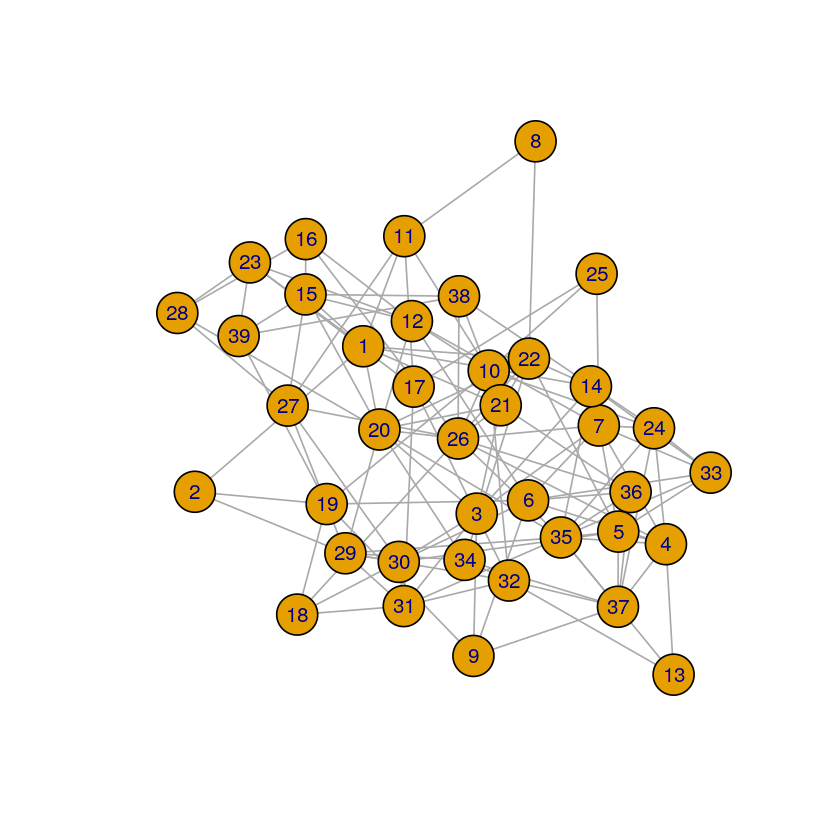

In [72]:
matPC <- makeSymm(dim(timeData)[1], adjPartCorUpper, 0.05)
graphPartCor <- graph_from_adjacency_matrix(matPC, mode = "undirected")
plot(graphPartCor)

In [73]:
mean(degree(graphPartCor))

[1] 6.410256

### Graphical Lasso

In [74]:
library(huge)

At $\lambda$ 0.8

In [78]:
hugeGL <- list()
hugeGL[["0.8"]] <- huge(t(timeData), method = "glasso", lambda = 0.8)
hugeGL[["0.6"]] <- huge(t(timeData), method = "glasso", lambda = 0.6)
hugeGL[["0.4"]] <- huge(t(timeData), method = "glasso", lambda = 0.4)
hugeGL[["0.2"]] <- huge(t(timeData), method = "glasso", lambda = 0.2)
hugeGL[["0.1"]] <- huge(t(timeData), method = "glasso", lambda = 0.1)

Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 100%
Conducting the graphical lasso (glasso)....done.                                          
Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 100%
Conducting the graphical lasso (glasso)....done.                                          


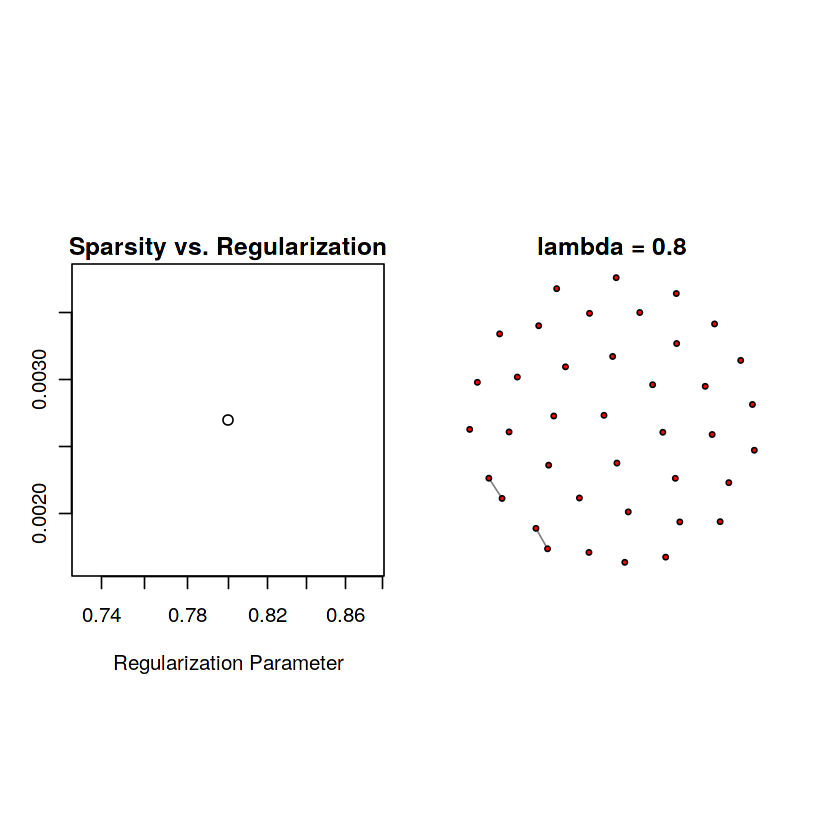

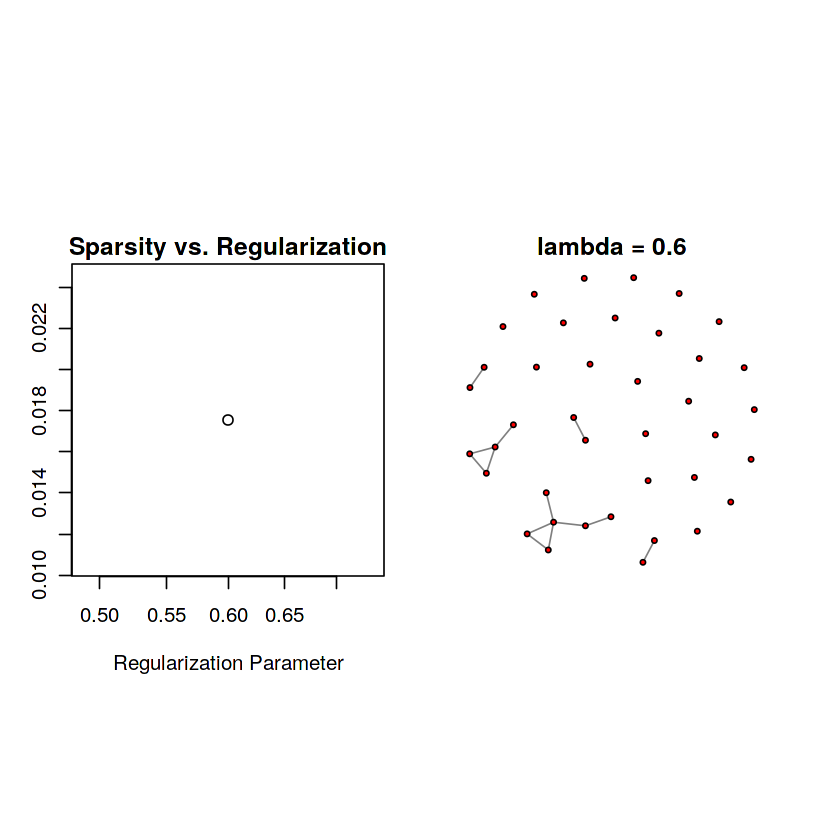

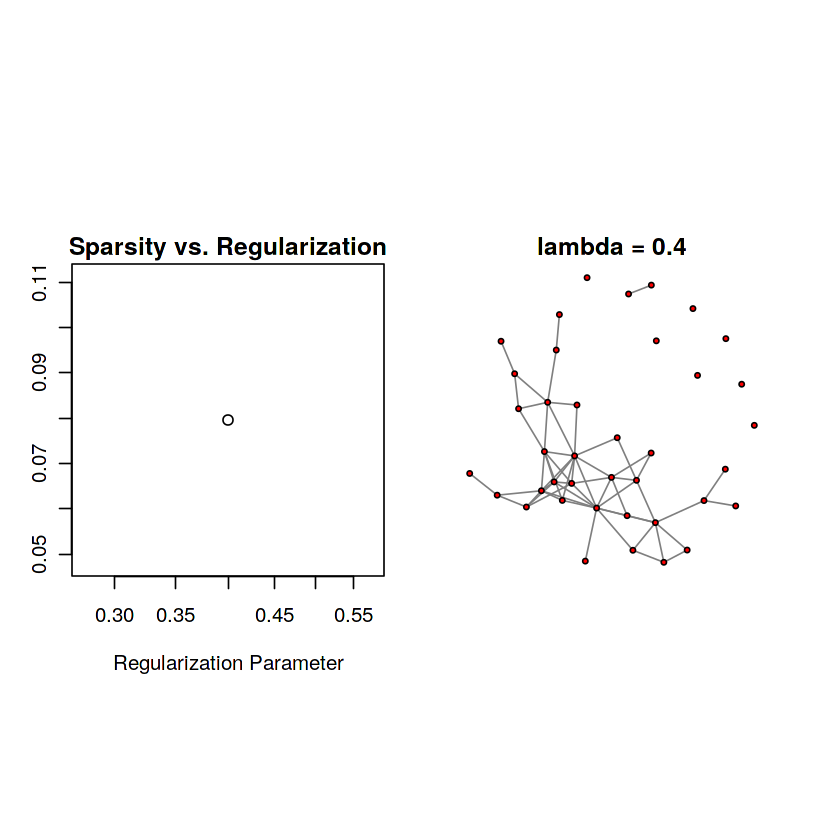

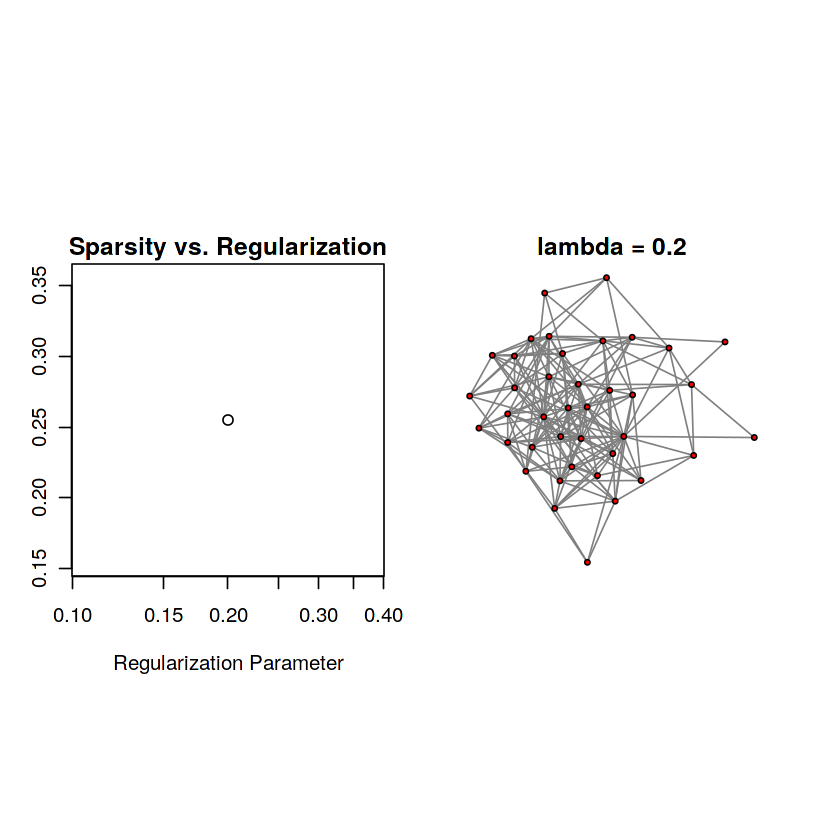

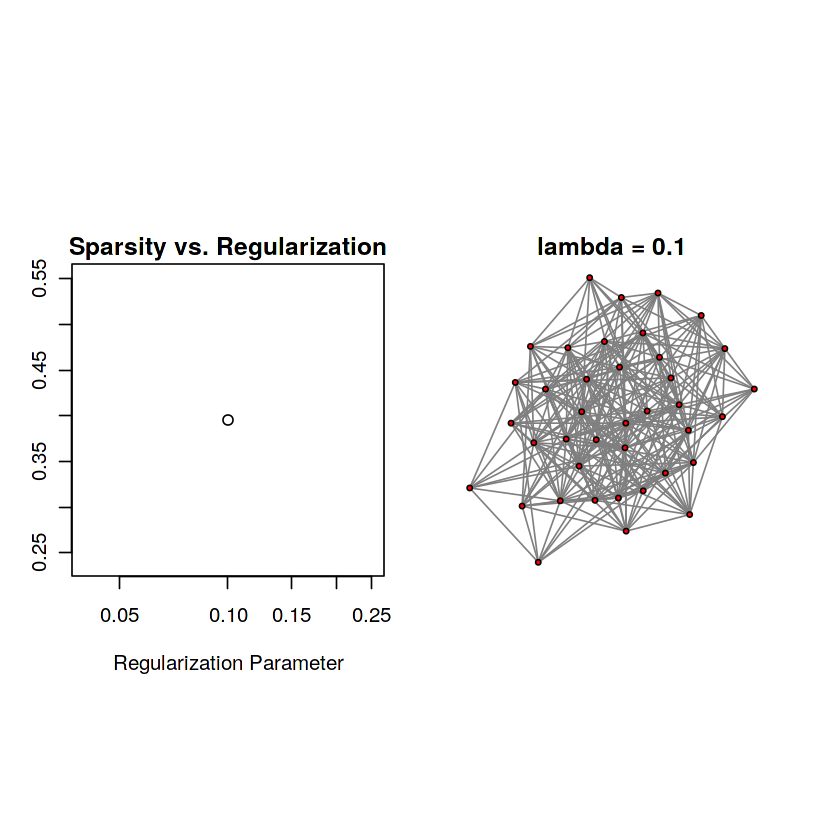

In [79]:
plot(hugeGL$`0.8`)
plot(hugeGL$`0.6`)
plot(hugeGL$`0.4`)
plot(hugeGL$`0.2`)
plot(hugeGL$`0.1`)

In [88]:
d <- lapply(hugeGL, function(g)
    {
    g <- graph_from_adjacency_matrix(g$path[[1]])
    mean(degree(g))
})
d

$`0.8`
[1] 0.2051282

$`0.6`
[1] 1.333333

$`0.4`
[1] 6.051282

$`0.2`
[1] 19.38462

$`0.1`
[1] 30.05128

Huge library for using graph lasso for inferring graph structure.
We try different values of lambda parameter for group lasso and see as we decrease the $\lambda$ density increases. At $\lambda$  0.1 the mean degree is near to the original correlation network while at $\lambda$ 0.4 mean degree is near to partial correlation network.

In [132]:
hugeGLOpt <- huge(t(timeData), method = "glasso")

Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 90%
Conducting the graphical lasso (glasso)....done.                                          


We further try different optimal criteria as suggested trying both RIC and subsampling

Conducting rotation information criterion (ric) selection....done
Computing the optimal graph....done
[1] 8


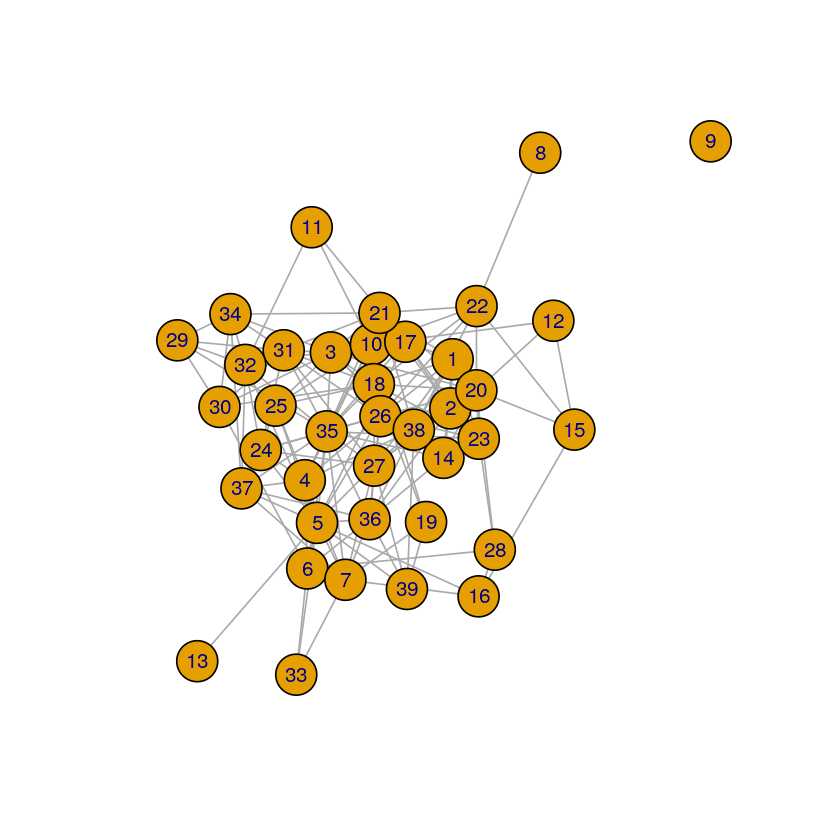

In [133]:
hugeRIC <- huge.select(hugeGLOpt, criterion = "ric")
gRIC <- graph_from_adjacency_matrix(hugeRIC$refit, mode = "undirected")
plot(gRIC)
print(mean(degree(gRIC)))

Conducting Subsampling....done.                  
[1] 3.692308


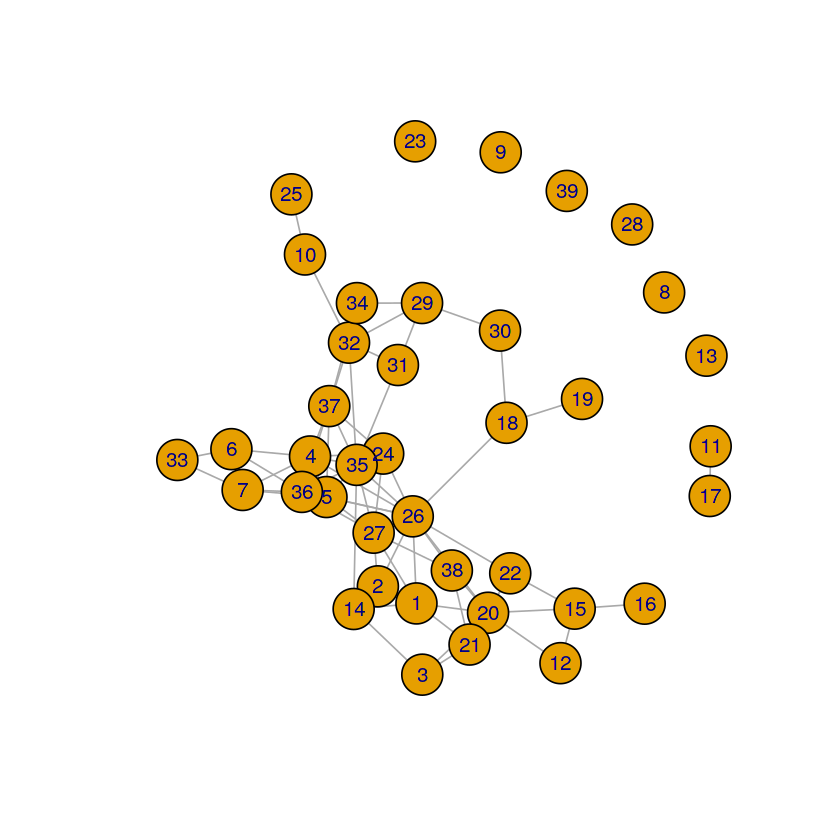

In [134]:
hugeStar <- huge.select(hugeGLOpt, criterion = "stars")
gStar <- graph_from_adjacency_matrix(hugeStar$refit, mode = "undirected")
plot(gStar)
print(mean(degree(gStar)))

In [135]:
gCP <- graph.intersection(graphCor, graphPartCor)
gSC <- graph.intersection(gStar, graphCor)
#gSPC <- graph.intersection(gStar, graphPartCor)

In [121]:
edges(g)[[1]]

Warning message in as.igraph.vs(graph, v):
“NAs introduced by coercion”


ERROR: Error in as.igraph.vs(graph, v): Invalid vertex name(s)
